# Spectral clustering on heterophilic SBMs
> Example of using spectral clustering when there is stronger connectivity between groups than within

- toc: false
- badges: true
- comments: true
- categories: [pedigo, graspologic]
- hide: false
- search_exclude: false

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.plot import heatmap
from graspologic.simulations import sbm
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm

SBMs will be sampled from the block probability matrix:
$$
B = \begin{bmatrix}
0.1 & a \\
b & 0.1
\end{bmatrix}
$$
with 50 nodes in each of the two blocks. Below, an example adjacency matrix is plotted
for $a = 0.3$ and $b = 0.4$.

<AxesSubplot: >

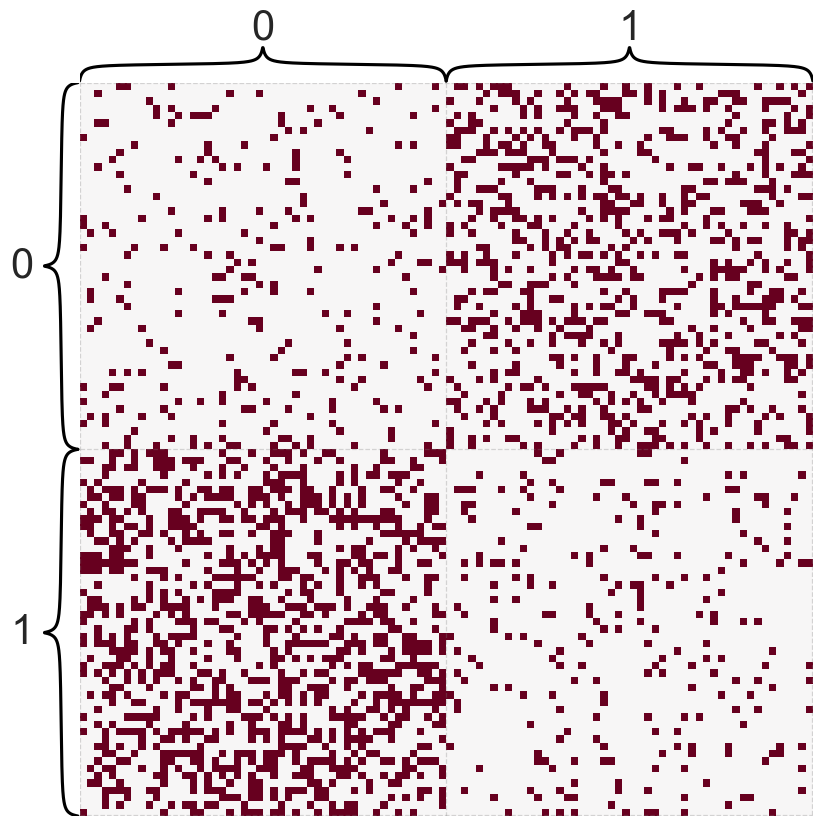

In [2]:
a = 0.3
b = 0.4
ns = [50, 50]
B = np.array([[0.1, a], [b, 0.1]])
A, labels = sbm(ns, B, directed=True, return_labels=True)
heatmap(A, inner_hier_labels=labels, cbar=False)

Below, I just run GMM on the adjacency spectral embedding of these sampled directed graphs. Note that I'm using the "concatenated" version of ASE from Sussman et al. 2012, i.e., clustering on a matrix whose columns are the left and right singular vectors of the adjacency. 


In [3]:
n_steps = 31
n_sims = 10
n_runs = n_steps**2 * n_sims
pbar = tqdm(total=n_runs)
rows = []
for i, a in enumerate(np.linspace(0.1, 0.9, n_steps)):
    for j, b in enumerate(np.linspace(0.1, 0.9, n_steps)):
        B = np.array([[0.1, a], [b, 0.1]])
        for _ in range(n_sims):
            A, labels = sbm(ns, B, directed=True, return_labels=True)
            ase = AdjacencySpectralEmbed(n_components=2, concat=True)
            X = ase.fit_transform(A)
            y_hat = GaussianMixture(n_components=2).fit_predict(X)
            ari = adjusted_rand_score(labels, y_hat)
            rows.append({"a": a, "b": b, "ari": ari, "i": i, "j": j})
            pbar.update(1)

  0%|          | 0/9610 [00:00<?, ?it/s]

Here I show average ARI (with respect to the true SBM labels, average over 10 runs)
for each pair of $a$ and $b$ values.

[Text(0.5, 0, '0.1'), Text(15.5, 0, '0.5'), Text(30.5, 0, '0.9')]

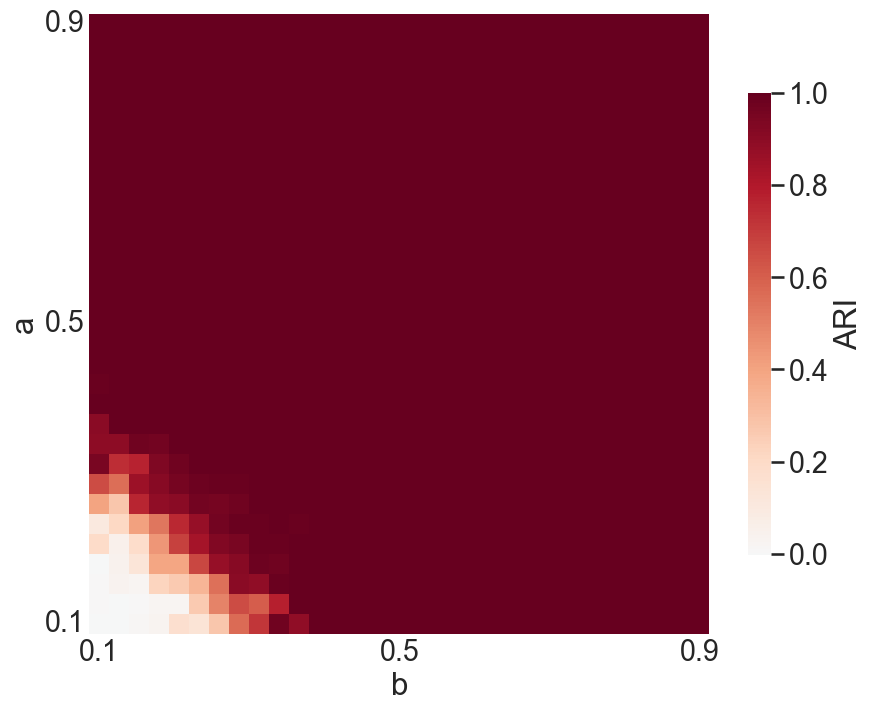

In [4]:

sns.set_context("talk", font_scale=1.25)
results = pd.DataFrame(rows)

pivot_results = results.pivot_table(index="a", columns="b", values="ari")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.heatmap(
    pivot_results,
    ax=ax,
    cmap="RdBu_r",
    center=0,
    square=True,
    cbar_kws=dict(shrink=0.6, label="ARI"),
)
ax.invert_yaxis()
ax.tick_params(axis="both", which="both", length=0)

ax.set(
    xticks=[0.5, 15.5, 30.5],
    xticklabels=[0.1, 0.5, 0.9],
    yticks=[0.5, 15.5, 30.5],
    yticklabels=[0.1, 0.5, 0.9],
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)